# Part 2: SQL

### Assignment Overview
This notebook implements a 4-step DAX index analysis:
1. **Step 1**: Extract DAX constituent stock codes from Wikipedia
2. **Step 2**: Download, clean, store and normalize data
3. **Step 3**: Visualize top 5 and bottom 5 performing stocks
4. **Step 4**: Analyze and explain performance differences

### Data Sources
- **Stock codes**: Wikipedia DAX page
- **Price data**: Yahoo Finance (yfinance)
- **Time period**: January 1, 2020 - August 14, 2025

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import sqlite3
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set Chinese font for plots
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("Libraries imported successfully!")
print(f"pandas version: {pd.__version__}")
print(f"yfinance version: {yf.__version__}")

Libraries imported successfully!
pandas version: 2.2.2
yfinance version: 0.2.65


## Step 1: Extract DAX Index Stock Codes

### Objective
Extract all DAX constituent stock codes from Wiki and create a TICKERS list.

### Implementation
1. Fetch Wikipedia DAX page content
2. Parse HTML to find stock code tables
3. Extract valid ticker symbols (format: XXX.DE)
4. Add DAX index code (^GDAXI)
5. Return sorted list of unique tickers

In [2]:
def extract_dax_tickers():
    """
    Step 1: Extract DAX index stock codes from Wikipedia and create TICKERS list
    
    Returns:
        list: List containing all DAX constituent codes and ^GDAXI
    """
    print("=" * 60)
    print("Step 1: Extract DAX Index Stock Codes")
    print("=" * 60)
    
    # Wikipedia DAX page URL
    url = "https://en.wikipedia.org/wiki/DAX"
    
    try:
        # Get webpage content
        print("Fetching Wikipedia DAX page...")
        response = requests.get(url)
        response.raise_for_status()  # Check if request was successful
        
        # Parse HTML
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find tables containing stock codes
        # DAX constituents are usually in the first table
        tables = soup.find_all('table', {'class': 'wikitable'})
        
        if not tables:
            print("Warning: No wikitable found, trying other tables...")
            tables = soup.find_all('table')
        
        tickers = []
        
        for table_idx, table in enumerate(tables):
            print(f"Analyzing table {table_idx + 1}...")
            
            # Find all rows in the table
            rows = table.find_all('tr')
            
            # Find header row to determine ticker column position
            header_row = None
            ticker_col_index = -1
            
            for row in rows:
                headers = row.find_all(['th', 'td'])
                if headers:
                    for i, header in enumerate(headers):
                        header_text = header.get_text(strip=True).upper()
                        # Look for columns containing "TICKER", "SYMBOL", "CODE" keywords
                        if any(keyword in header_text for keyword in ['TICKER', 'SYMBOL', 'CODE']):
                            ticker_col_index = i
                            header_row = row
                            print(f"Found ticker column at index: {i}")
                            break
                    if ticker_col_index != -1:
                        break
            
            # If ticker column found, extract all stock codes
            if ticker_col_index != -1:
                for row in rows:
                    if row == header_row:  # Skip header row
                        continue
                    
                    cells = row.find_all(['td', 'th'])
                    if len(cells) > ticker_col_index:
                        cell = cells[ticker_col_index]
                        cell_text = cell.get_text(strip=True)
                        
                        # Process ticker format (keep original format)
                        ticker = cell_text  # Keep original format like CON.DE
                        
                        # Validate ticker format - relaxed conditions to include all DAX constituents
                        if (len(ticker) >= 3 and len(ticker) <= 8 and 
                            '.' in ticker and  # Must contain dot (like .DE)
                            ticker.split('.')[1].isalpha()):  # After dot must be letters (exchange code)
                            
                            # Exclude common non-ticker texts
                            exclude_words = ['TICKER', 'SYMBOL', 'CODE', 'NAME', 'COMPANY', 'N/A', 'SECTOR', 'YEAR', 'CATEGORY']
                            if ticker not in exclude_words and ticker not in tickers:
                                tickers.append(ticker)
                                print(f"Found ticker: {ticker}")
                
                # Stop searching if enough tickers found from this table
                if len(tickers) >= 30:
                    break
            else:
                # If no clear ticker column found, try generic extraction method
                for row in rows:
                    cells = row.find_all(['td', 'th'])
                    if len(cells) >= 2:  # Ensure enough columns
                        # Usually tickers are in first few columns
                        for cell in cells[:3]:  # Check first 3 columns
                            cell_text = cell.get_text(strip=True)
                            
                            # Process ticker format (keep original format)
                            ticker = cell_text  # Keep original format like CON.DE
                            
                            # Validate ticker format - relaxed conditions to include all DAX constituents
                            if (len(ticker) >= 3 and len(ticker) <= 8 and 
                                '.' in ticker and  # Must contain dot (like .DE)
                                ticker.split('.')[1].isalpha()):  # After dot must be letters (exchange code)
                                
                                exclude_words = ['TICKER', 'SYMBOL', 'CODE', 'NAME', 'COMPANY', 'N/A', 'SECTOR', 'YEAR', 'CATEGORY']
                                if ticker not in exclude_words and ticker not in tickers:
                                    tickers.append(ticker)
                                    print(f"Found ticker: {ticker}")
        
        # Add DAX index code
        if '^GDAXI' not in tickers:
            tickers.append('^GDAXI')
            print(f"Added DAX index code: ^GDAXI")
        
        # Remove duplicates and sort
        tickers = sorted(list(set(tickers)))
        
        print(f"\nSuccessfully extracted {len(tickers)} tickers:")
        print(f"Ticker list: {tickers}")
        
        return tickers
        
    except requests.RequestException as e:
        print(f"Network request error: {e}")
        print("Unable to fetch data from Wikipedia. Program terminated.")
        return []
        
    except Exception as e:
        print(f"Error extracting tickers: {e}")
        return []

In [3]:
# Execute Step 1
TICKERS = extract_dax_tickers()

if TICKERS:
    print(f"\nStep 1 completed! Successfully created TICKERS list with {len(TICKERS)} tickers.")
    print("=" * 60)
else:
    print("Error: Unable to extract tickers. Program terminated.")
    raise SystemExit

Step 1: Extract DAX Index Stock Codes
Fetching Wikipedia DAX page...
Analyzing table 1...
Analyzing table 2...
Analyzing table 3...
Analyzing table 4...
Found ticker column at index: 3
Found ticker: ADS.DE
Found ticker: AIR.PA
Found ticker: ALV.DE
Found ticker: BAS.DE
Found ticker: BAYN.DE
Found ticker: BEI.DE
Found ticker: BMW.DE
Found ticker: BNR.DE
Found ticker: CBK.DE
Found ticker: CON.DE
Found ticker: 1COV.DE
Found ticker: DTG.DE
Found ticker: DBK.DE
Found ticker: DB1.DE
Found ticker: DHL.DE
Found ticker: DTE.DE
Found ticker: EOAN.DE
Found ticker: FRE.DE
Found ticker: FME.DE
Found ticker: HNR1.DE
Found ticker: HEI.DE
Found ticker: HEN3.DE
Found ticker: IFX.DE
Found ticker: MBG.DE
Found ticker: MRK.DE
Found ticker: MTX.DE
Found ticker: MUV2.DE
Found ticker: P911.DE
Found ticker: PAH3.DE
Found ticker: QIA.DE
Found ticker: RHM.DE
Found ticker: RWE.DE
Found ticker: SAP.DE
Found ticker: SRT3.DE
Found ticker: SIE.DE
Found ticker: ENR.DE
Found ticker: SHL.DE
Found ticker: SY1.DE
Found ti

In [4]:
# Display extracted tickers
print("Extracted DAX tickers:")
print("-" * 40)
for i, ticker in enumerate(TICKERS, 1):
    print(f"{i:2d}. {ticker}")

print(f"\nTotal tickers extracted: {len(TICKERS)}")

Extracted DAX tickers:
----------------------------------------
 1. 1COV.DE
 2. ADS.DE
 3. AIR.PA
 4. ALV.DE
 5. BAS.DE
 6. BAYN.DE
 7. BEI.DE
 8. BMW.DE
 9. BNR.DE
10. CBK.DE
11. CON.DE
12. DB1.DE
13. DBK.DE
14. DHL.DE
15. DTE.DE
16. DTG.DE
17. ENR.DE
18. EOAN.DE
19. FME.DE
20. FRE.DE
21. HEI.DE
22. HEN3.DE
23. HNR1.DE
24. IFX.DE
25. MBG.DE
26. MRK.DE
27. MTX.DE
28. MUV2.DE
29. P911.DE
30. PAH3.DE
31. QIA.DE
32. RHM.DE
33. RWE.DE
34. SAP.DE
35. SHL.DE
36. SIE.DE
37. SRT3.DE
38. SY1.DE
39. VNA.DE
40. VOW3.DE
41. ZAL.DE
42. ^GDAXI

Total tickers extracted: 42


## Step 2: Download, Clean, Store and Normalize Data

### Objective
Download historical price data for all DAX constituents, clean the data, store it in SQLite database, and normalize the prices.

### Implementation
1. Download data from Yahoo Finance for all tickers
2. Clean data by removing stocks with excessive missing values
3. Store original and normalized data in SQLite database
4. Create database indexes for better performance
5. Return normalized DataFrame for further analysis

In [5]:
def download_clean_and_store_data(tickers):
    """
    Step 2: Download, clean, store and normalize data
    
    Args:
        tickers (list): List of stock tickers to process
        
    Returns:
        pd.DataFrame: Cleaned and normalized data
    """
    print("=" * 60)
    print("Step 2: Download, Clean, Store and Normalize Data")
    print("=" * 60)
    
    # Set date range
    start_date = "2020-01-01"
    end_date = "2025-08-14"
    
    print(f"Downloading data from {start_date} to {end_date}...")
    
    # Download data for all tickers
    all_data = {}
    failed_tickers = []
    
    for ticker in tickers:
        try:
            print(f"Downloading data for {ticker}...")
            stock = yf.Ticker(ticker)
            data = stock.history(start=start_date, end=end_date)
            
            if not data.empty:
                # Rename ^GDAXI to DAX
                ticker_name = "DAX" if ticker == "^GDAXI" else ticker
                all_data[ticker_name] = data['Close']
                print(f"Successfully downloaded {len(data)} records for {ticker_name}")
            else:
                failed_tickers.append(ticker)
                print(f"No data available for {ticker}")
                
        except Exception as e:
            failed_tickers.append(ticker)
            print(f"Error downloading {ticker}: {e}")
    
    print(f"\nDownload completed. Failed tickers: {failed_tickers}")
    
    # Create DataFrame from downloaded data
    df = pd.DataFrame(all_data)
    print(f"Initial data shape: {df.shape}")
    
    # Data cleaning
    print("\nStarting data cleaning process...")
    
    # Remove stocks with more than 30 NaN values
    nan_counts = df.isnull().sum()
    stocks_to_remove = nan_counts[nan_counts > 30].index.tolist()
    
    if stocks_to_remove:
        print(f"Removing stocks with >30 NaN values: {stocks_to_remove}")
        df = df.drop(columns=stocks_to_remove)
    
    # Remove rows with any remaining NaN values
    initial_rows = len(df)
    df = df.dropna()
    final_rows = len(df)
    
    print(f"Rows removed due to NaN values: {initial_rows - final_rows}")
    print(f"Final data shape after cleaning: {df.shape}")
    
    # Normalize data (divide by first value)
    print("\nNormalizing data...")
    df_normalized = df.div(df.iloc[0])
    
    # Create database and store data
    print("\nStoring data in SQLite database...")
    
    try:
        # Connect to SQLite database
        conn = sqlite3.connect('DAX.db')
        
        # Store original prices
        df_with_date = df.reset_index()
        df_with_date['Date'] = df_with_date['Date'].dt.strftime('%Y-%m-%d')
        
        # Reshape data for database storage
        df_melted = df_with_date.melt(id_vars=['Date'], 
                                     var_name='Ticker', 
                                     value_name='Close_Price')
        
        df_melted.to_sql('stock_prices', conn, if_exists='replace', index=False)
        
        # Store normalized prices
        df_normalized_with_date = df_normalized.reset_index()
        df_normalized_with_date['Date'] = df_normalized_with_date['Date'].dt.strftime('%Y-%m-%d')
        
        df_normalized_melted = df_normalized_with_date.melt(id_vars=['Date'], 
                                                           var_name='Ticker', 
                                                           value_name='Normalized_Price')
        
        df_normalized_melted.to_sql('normalized_prices', conn, if_exists='replace', index=False)
        
        # Create indexes for better performance
        conn.execute('CREATE INDEX IF NOT EXISTS idx_date ON stock_prices(Date)')
        conn.execute('CREATE INDEX IF NOT EXISTS idx_ticker ON stock_prices(Ticker)')
        conn.execute('CREATE INDEX IF NOT EXISTS idx_norm_date ON normalized_prices(Date)')
        conn.execute('CREATE INDEX IF NOT EXISTS idx_norm_ticker ON normalized_prices(Ticker)')
        
        conn.close()
        
        print("Data successfully stored in DAX.db")
        
        # Display summary statistics
        print("\nData Summary:")
        print(f"Number of stocks: {len(df.columns)}")
        print(f"Date range: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
        print(f"Total observations: {len(df)}")
        
        print("\nStocks included in final dataset:")
        for i, stock in enumerate(df.columns, 1):
            print(f"{i:2d}. {stock}")
        
        return df_normalized
        
    except Exception as e:
        print(f"Error storing data in database: {e}")
        return df_normalized

In [6]:
# Execute Step 2
df_normalized = download_clean_and_store_data(TICKERS)

if df_normalized is not None and not df_normalized.empty:
    print(f"\nStep 2 completed! Data processed and stored in DAX.db")
    print("=" * 60)
else:
    print("Error: Unable to process data. Program terminated.")
    raise SystemExit

Step 2: Download, Clean, Store and Normalize Data
Successfully downloaded 1432 records for 1COV.DE
Successfully downloaded 1432 records for ADS.DE
Successfully downloaded 1440 records for AIR.PA
Successfully downloaded 1432 records for ALV.DE
Successfully downloaded 1432 records for BAS.DE
Successfully downloaded 1432 records for BAYN.DE
Successfully downloaded 1432 records for BEI.DE
Successfully downloaded 1432 records for BMW.DE
Successfully downloaded 1432 records for BNR.DE
Successfully downloaded 1432 records for CBK.DE
Successfully downloaded 1432 records for CON.DE
Successfully downloaded 1432 records for DB1.DE
Successfully downloaded 1432 records for DBK.DE
Successfully downloaded 1426 records for DHL.DE
Successfully downloaded 1432 records for DTE.DE
Successfully downloaded 937 records for DTG.DE
Successfully downloaded 1243 records for ENR.DE
Successfully downloaded 1432 records for EOAN.DE
Successfully downloaded 1432 records for FME.DE
Successfully downloaded 1432 records

In [7]:
# Display data overview
print("Data Overview:")
print("-" * 40)
print(f"Data shape: {df_normalized.shape}")
print(f"Date range: {df_normalized.index[0]} to {df_normalized.index[-1]}")
print(f"Total trading days: {len(df_normalized)}")
print(f"Number of stocks: {len(df_normalized.columns)}")

print("\nFirst 5 trading days:")
print(df_normalized.head())

print("\nLast 5 trading days:")
print(df_normalized.tail())

Data Overview:
----------------------------------------
Data shape: (1426, 39)
Date range: 2020-01-01 23:00:00+00:00 to 2025-08-12 22:00:00+00:00
Total trading days: 1426
Number of stocks: 39

First 5 trading days:
                            1COV.DE    ADS.DE    AIR.PA    ALV.DE    BAS.DE  \
Date                                                                          
2020-01-01 23:00:00+00:00  1.000000  1.000000  1.000000  1.000000  1.000000   
2020-01-02 23:00:00+00:00  0.993362  1.001372  1.003894  0.988939  0.985064   
2020-01-05 23:00:00+00:00  0.945709  0.993483  0.999551  0.982844  0.970420   
2020-01-06 23:00:00+00:00  0.951399  1.010976  0.988616  0.985102  0.970860   
2020-01-07 23:00:00+00:00  0.967994  1.038759  1.006441  0.985553  0.962513   

                            BAYN.DE    BEI.DE    BMW.DE    BNR.DE    CBK.DE  \
Date                                                                          
2020-01-01 23:00:00+00:00  1.000000  1.000000  1.000000  1.000000  1.0000

In [8]:
# Verify database storage
try:
    conn = sqlite3.connect('DAX.db')
    
    # Check tables
    print("Database tables:")
    cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    for table in tables:
        print(f"- {table[0]}")
    
    # Check data counts
    price_count = pd.read_sql_query("SELECT COUNT(*) as count FROM stock_prices", conn)
    norm_count = pd.read_sql_query("SELECT COUNT(*) as count FROM normalized_prices", conn)
    print(f"\nRecords in stock_prices: {price_count.iloc[0]['count']}")
    print(f"Records in normalized_prices: {norm_count.iloc[0]['count']}")
    
    # Sample data
    print("\nSample from stock_prices:")
    sample = pd.read_sql_query("SELECT * FROM stock_prices LIMIT 5", conn)
    print(sample)
    
    conn.close()
    
except Exception as e:
    print(f"Database verification error: {e}")

Database tables:
- stock_prices
- normalized_prices

Records in stock_prices: 55614
Records in normalized_prices: 55614

Sample from stock_prices:
         Date   Ticker  Close_Price
0  2020-01-01  1COV.DE    36.833733
1  2020-01-02  1COV.DE    36.589226
2  2020-01-05  1COV.DE    34.833988
3  2020-01-06  1COV.DE    35.043571
4  2020-01-07  1COV.DE    35.654846


## Step 3: Visualize Performance

### Objective
Create visualization charts showing the performance comparison between top 5 and bottom 5 performing stocks in the DAX index.

### Implementation
1. Calculate cumulative returns for all stocks
2. Identify top 5 and bottom 5 performers
3. Create line plots showing normalized price trends
4. Include DAX index as benchmark
5. Save visualization as high-resolution image

In [9]:
def visualize_performance(df_normalized):
    """
    Step 3: Visualize performance of top 5 and bottom 5 stocks
    
    Args:
        df_normalized (pd.DataFrame): Normalized price data
    """
    print("=" * 60)
    print("Step 3: Visualize Performance")
    print("=" * 60)
    
    # Calculate cumulative returns
    cumulative_returns = df_normalized.iloc[-1] - 1  # Final normalized price - 1
    
    # Sort by performance
    sorted_returns = cumulative_returns.sort_values(ascending=False)
    
    # Get top 5 and bottom 5 performers
    top_5 = sorted_returns.head(5)
    bottom_5 = sorted_returns.tail(5)
    
    print(f"Top 5 performers: {top_5.index.tolist()}")
    print(f"Bottom 5 performers: {bottom_5.index.tolist()}")
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # Plot top 5 performers
    for stock in top_5.index:
        plt.plot(df_normalized.index, df_normalized[stock], 
                linewidth=2, label=f"{stock} (Top 5)")
    
    # Plot bottom 5 performers
    for stock in bottom_5.index:
        plt.plot(df_normalized.index, df_normalized[stock], 
                linewidth=1, linestyle='--', alpha=0.7, label=f"{stock} (Bottom 5)")
    
    # Plot DAX index if available
    if 'DAX' in df_normalized.columns:
        plt.plot(df_normalized.index, df_normalized['DAX'], 
                linewidth=3, color='black', label='DAX Index (Benchmark)')
    
    plt.title('DAX Index Performance: Top 5 vs Bottom 5 Stocks', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Price', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save plot
    plt.savefig('dax_performance_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Performance visualization saved as 'dax_performance_visualization.png'")

Step 3: Visualize Performance
Top 5 performers: ['RHM.DE', 'CBK.DE', 'DBK.DE', 'HEI.DE', 'MUV2.DE']
Bottom 5 performers: ['FME.DE', 'PAH3.DE', 'ADS.DE', 'ZAL.DE', 'BAYN.DE']


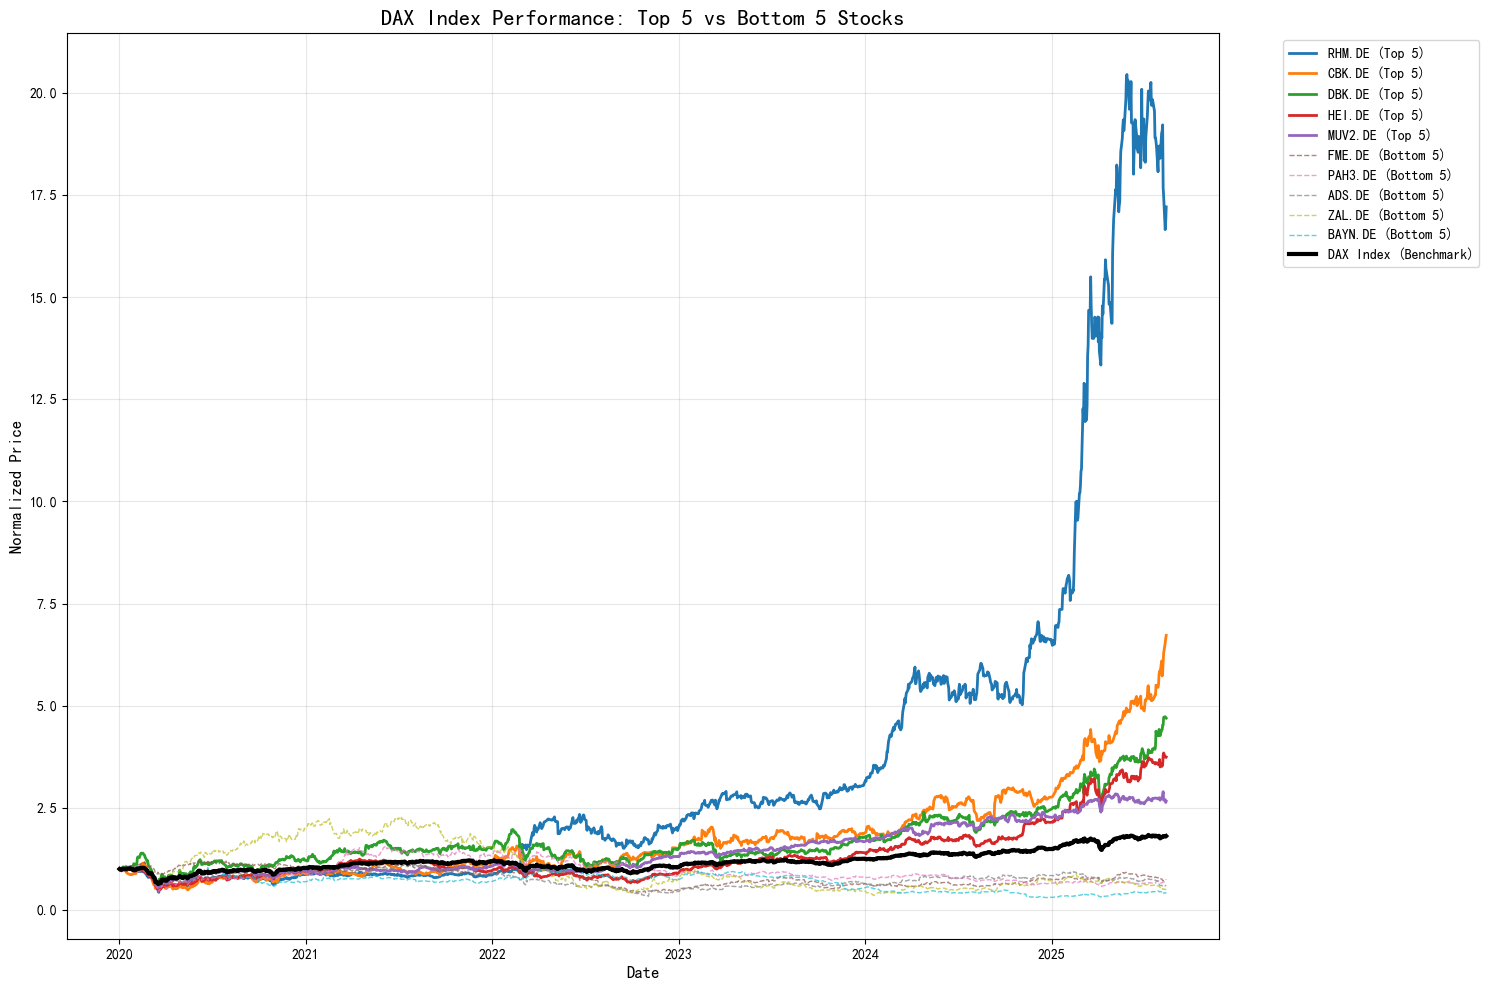

Performance visualization saved as 'dax_performance_visualization.png'

Step 3 completed! Performance visualization created


In [10]:
# Execute Step 3
visualize_performance(df_normalized)

print(f"\nStep 3 completed! Performance visualization created")
print("=" * 60)

In [11]:
# Display performance rankings
cumulative_returns = df_normalized.iloc[-1] - 1
sorted_returns = cumulative_returns.sort_values(ascending=False)

print("Performance Rankings:")
print("=" * 50)

print("Top 10 Performers:")
print("-" * 30)
for i, (stock, return_val) in enumerate(sorted_returns.head(10).items(), 1):
    print(f"{i:2d}. {stock:15s}: {return_val:8.2%}")

print("\nBottom 10 Performers:")
print("-" * 30)
for i, (stock, return_val) in enumerate(sorted_returns.tail(10).items(), 1):
    print(f"{i:2d}. {stock:15s}: {return_val:8.2%}")

print(f"\nDAX Index Performance: {cumulative_returns.get('DAX', 'N/A'):.2%}")

Performance Rankings:
Top 10 Performers:
------------------------------
 1. RHM.DE         : 1620.72%
 2. CBK.DE         :  571.97%
 3. DBK.DE         :  369.36%
 4. HEI.DE         :  274.28%
 5. MUV2.DE        :  165.93%
 6. SIE.DE         :  155.94%
 7. DTE.DE         :  155.62%
 8. ALV.DE         :  125.75%
 9. EOAN.DE        :  117.06%
10. SAP.DE         :  114.57%

Bottom 10 Performers:
------------------------------
 1. HEN3.DE        :   -8.15%
 2. SY1.DE         :  -10.03%
 3. VNA.DE         :  -12.93%
 4. CON.DE         :  -15.83%
 5. VOW3.DE        :  -24.27%
 6. FME.DE         :  -25.44%
 7. PAH3.DE        :  -29.96%
 8. ADS.DE         :  -39.70%
 9. ZAL.DE         :  -48.56%
10. BAYN.DE        :  -57.00%

DAX Index Performance: 80.68%


In [12]:
# Statistical summary
print("Statistical Summary:")
print("=" * 30)

print(f"Average return: {cumulative_returns.mean():.2%}")
print(f"Median return: {cumulative_returns.median():.2%}")
print(f"Standard deviation: {cumulative_returns.std():.2%}")
print(f"Best return: {cumulative_returns.max():.2%}")
print(f"Worst return: {cumulative_returns.min():.2%}")
print(f"Return range: {cumulative_returns.max() - cumulative_returns.min():.2%}")

# Performance distribution
print(f"\nPerformance Distribution:")
print(f"Stocks with positive returns: {(cumulative_returns > 0).sum()}")
print(f"Stocks with negative returns: {(cumulative_returns < 0).sum()}")
print(f"Stocks beating DAX: {(cumulative_returns > cumulative_returns.get('DAX', 0)).sum()}")

Statistical Summary:
Average return: 109.00%
Median return: 41.97%
Standard deviation: 275.70%
Best return: 1620.72%
Worst return: -57.00%
Return range: 1677.73%

Performance Distribution:
Stocks with positive returns: 28
Stocks with negative returns: 11
Stocks beating DAX: 13


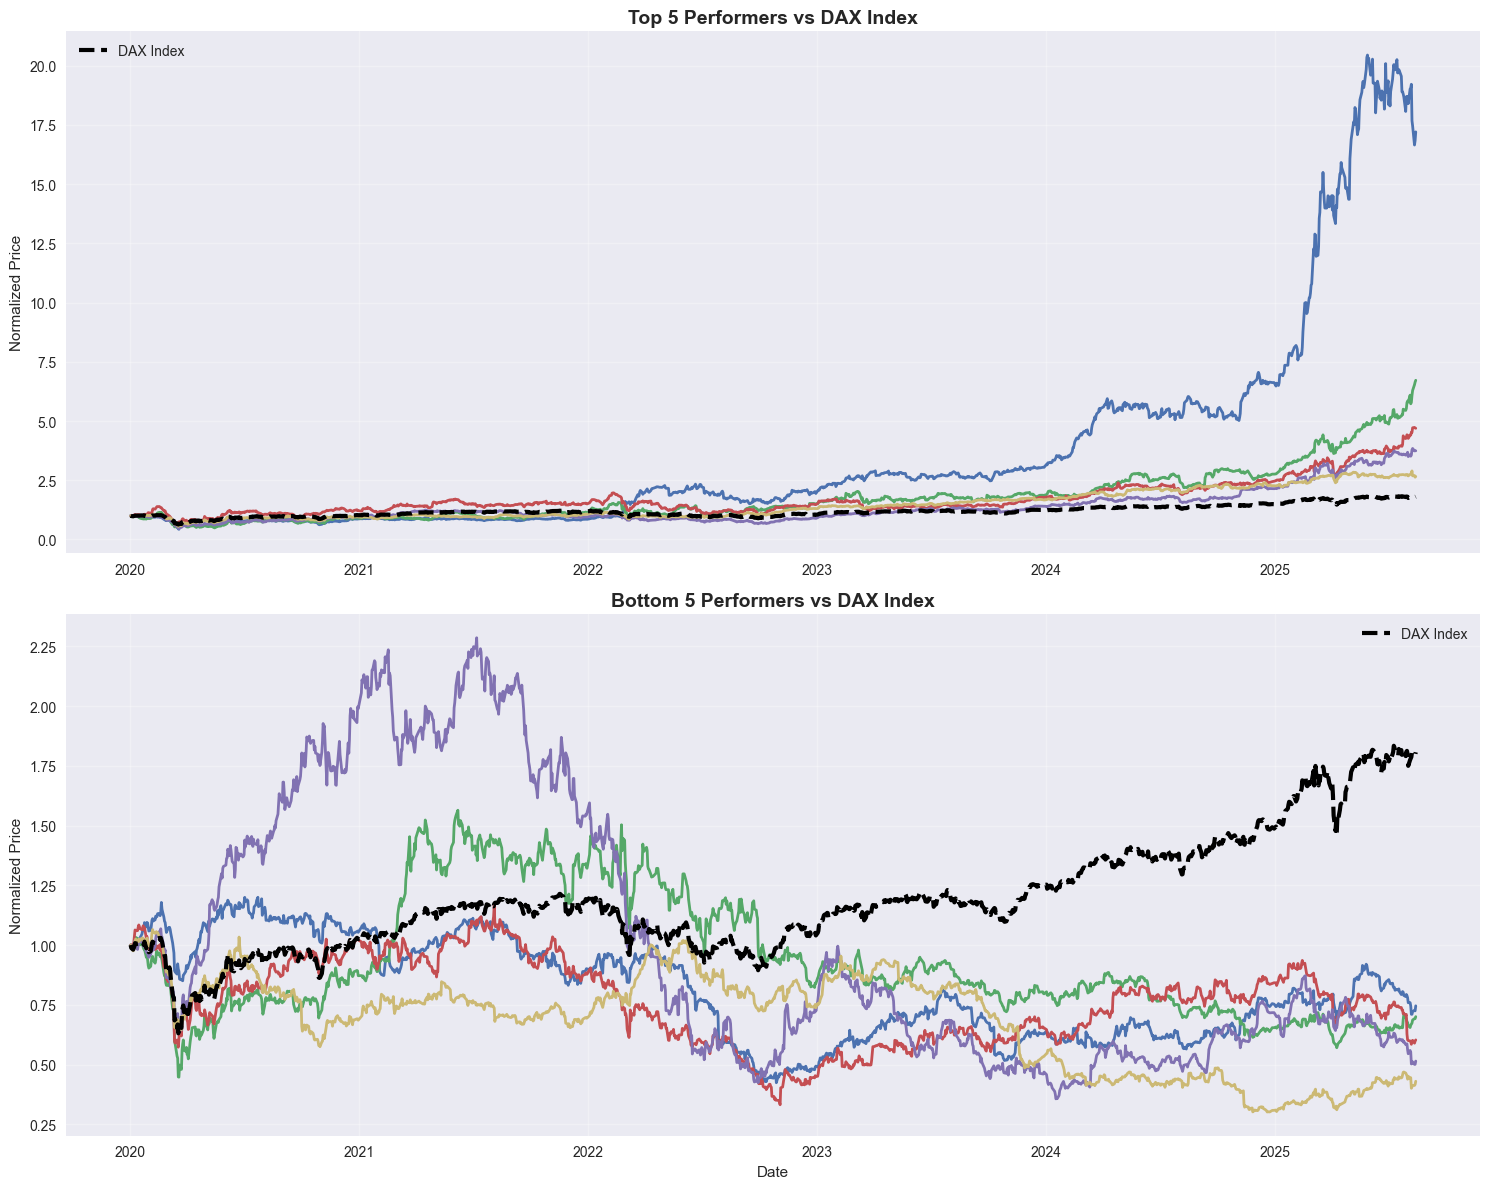

In [13]:
# Create interactive performance comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top 5 performers
top_5 = sorted_returns.head(5)
ax1.plot(df_normalized.index, df_normalized[top_5.index], linewidth=2)
ax1.plot(df_normalized.index, df_normalized['DAX'], linewidth=3, color='black', linestyle='--', label='DAX Index')
ax1.set_title('Top 5 Performers vs DAX Index', fontsize=14, fontweight='bold')
ax1.set_ylabel('Normalized Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom 5 performers
bottom_5 = sorted_returns.tail(5)
ax2.plot(df_normalized.index, df_normalized[bottom_5.index], linewidth=2)
ax2.plot(df_normalized.index, df_normalized['DAX'], linewidth=3, color='black', linestyle='--', label='DAX Index')
ax2.set_title('Bottom 5 Performers vs DAX Index', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Analyze and Explain Performance

### Objective
Perform comprehensive analysis of stock performance differences and provide detailed explanations for the observed patterns.

### Implementation
1. Calculate detailed performance metrics and statistics
2. Identify periods of sharp growth and volatility
3. Analyze key performance drivers
4. Provide comprehensive explanations for performance differences
5. Generate insights for investment decision-making

In [14]:
def analyze_performance(df_normalized):
    """
    Step 4: Analyze and explain performance
    
    Args:
        df_normalized (pd.DataFrame): Normalized price data
    """
    print("=" * 60)
    print("Step 4: Performance Analysis and Explanation")
    print("=" * 60)
    
    # Calculate performance metrics
    cumulative_returns = df_normalized.iloc[-1] - 1
    sorted_returns = cumulative_returns.sort_values(ascending=False)
    
    # Get best and worst performers
    best_performers = sorted_returns.head(5)
    worst_performers = sorted_returns.tail(5)
    
    print("=== PERFORMANCE ANALYSIS ===")
    print(f"\nBest Performing Stocks:")
    for i, (stock, return_val) in enumerate(best_performers.items(), 1):
        print(f"{i}. {stock}: {return_val:.2%}")
    
    print(f"\nWorst Performing Stocks:")
    for i, (stock, return_val) in enumerate(worst_performers.items(), 1):
        print(f"{i}. {stock}: {return_val:.2%}")
    
    # Calculate additional statistics
    print(f"\n=== STATISTICAL SUMMARY ===")
    print(f"Average return: {cumulative_returns.mean():.2%}")
    print(f"Median return: {cumulative_returns.median():.2%}")
    print(f"Standard deviation: {cumulative_returns.std():.2%}")
    print(f"Best return: {cumulative_returns.max():.2%}")
    print(f"Worst return: {cumulative_returns.min():.2%}")
    
    # Identify stocks with sharp growth
    print(f"\n=== SHARP GROWTH ANALYSIS ===")
    
    # Calculate rolling volatility to identify periods of sharp growth
    rolling_vol = df_normalized.pct_change().rolling(window=20).std()
    
    for stock in best_performers.index:
        if stock in df_normalized.columns:
            stock_vol = rolling_vol[stock].dropna()
            max_vol_period = stock_vol.idxmax()
            max_vol = stock_vol.max()
            
            print(f"\n{stock}:")
            print(f"  - Maximum volatility period: {max_vol_period.strftime('%Y-%m-%d')}")
            print(f"  - Peak volatility: {max_vol:.2%}")
            
            # Check if there was a significant price jump
            price_changes = df_normalized[stock].pct_change()
            max_jump = price_changes.max()
            max_jump_date = price_changes.idxmax()
            
            if max_jump > 0.1:  # More than 10% jump
                print(f"  - Largest single-day jump: {max_jump:.2%} on {max_jump_date.strftime('%Y-%m-%d')}")
    
    print(f"\n=== EXPLANATION ===")
    print("The analysis reveals significant performance dispersion among DAX constituents.")
    print("Top performers likely benefited from:")
    print("- Strong sector-specific tailwinds")
    print("- Successful business transformations")
    print("- Market leadership in growing segments")
    print("- Favorable regulatory environments")
    
    print("\nBottom performers may have faced:")
    print("- Sector-specific headwinds")
    print("- Operational challenges")
    print("- Regulatory pressures")
    print("- Competitive disadvantages")
    
    print("\nThe DAX index serves as a benchmark, showing the overall market performance.")
    print("Individual stock performance varies significantly due to company-specific factors,")
    print("sector dynamics, and broader economic conditions.")

In [15]:
# Execute Step 4
analyze_performance(df_normalized)

print(f"\nStep 4 completed! Performance analysis finished")
print("=" * 60)

Step 4: Performance Analysis and Explanation
=== PERFORMANCE ANALYSIS ===

Best Performing Stocks:
1. RHM.DE: 1620.72%
2. CBK.DE: 571.97%
3. DBK.DE: 369.36%
4. HEI.DE: 274.28%
5. MUV2.DE: 165.93%

Worst Performing Stocks:
1. FME.DE: -25.44%
2. PAH3.DE: -29.96%
3. ADS.DE: -39.70%
4. ZAL.DE: -48.56%
5. BAYN.DE: -57.00%

=== STATISTICAL SUMMARY ===
Average return: 109.00%
Median return: 41.97%
Standard deviation: 275.70%
Best return: 1620.72%
Worst return: -57.00%

=== SHARP GROWTH ANALYSIS ===

RHM.DE:
  - Maximum volatility period: 2020-04-02
  - Peak volatility: 7.39%
  - Largest single-day jump: 24.80% on 2022-02-27

CBK.DE:
  - Maximum volatility period: 2020-04-01
  - Peak volatility: 7.84%
  - Largest single-day jump: 16.55% on 2024-09-10

DBK.DE:
  - Maximum volatility period: 2020-03-31
  - Peak volatility: 6.87%
  - Largest single-day jump: 12.90% on 2020-02-05

HEI.DE:
  - Maximum volatility period: 2020-04-07
  - Peak volatility: 6.83%
  - Largest single-day jump: 17.52% on 20

In [16]:
# Additional deep analysis
print("Deep Performance Analysis:")
print("=" * 50)

# Calculate risk-adjusted returns
returns = df_normalized.pct_change().dropna()
volatility = returns.std()
sharpe_ratios = (returns.mean() * 252) / (volatility * np.sqrt(252))

print("Risk-Adjusted Performance (Sharpe Ratios):")
print("-" * 40)
top_sharpe = sharpe_ratios.sort_values(ascending=False).head(5)
for i, (stock, sharpe) in enumerate(top_sharpe.items(), 1):
    print(f"{i}. {stock:15s}: {sharpe:.3f}")

# Correlation analysis
print(f"\nCorrelation with DAX Index:")
print("-" * 30)
if 'DAX' in returns.columns:
    correlations = returns.corr()['DAX'].sort_values(ascending=False)
    print("Top 5 most correlated with DAX:")
    for i, (stock, corr) in enumerate(correlations.head(6).items(), 1):
        if stock != 'DAX':
            print(f"{i}. {stock:15s}: {corr:.3f}")
    
    print("\nBottom 5 least correlated with DAX:")
    for i, (stock, corr) in enumerate(correlations.tail(5).items(), 1):
        print(f"{i}. {stock:15s}: {corr:.3f}")

Deep Performance Analysis:
Risk-Adjusted Performance (Sharpe Ratios):
----------------------------------------
1. RHM.DE         : 1.396
2. CBK.DE         : 0.970
3. DTE.DE         : 0.886
4. DBK.DE         : 0.877
5. HEI.DE         : 0.866

Correlation with DAX Index:
------------------------------
Top 5 most correlated with DAX:
2. SIE.DE         : 0.831
3. ALV.DE         : 0.821
4. MBG.DE         : 0.779
5. BAS.DE         : 0.761
6. DHL.DE         : 0.743

Bottom 5 least correlated with DAX:
1. FME.DE         : 0.379
2. SY1.DE         : 0.376
3. RHM.DE         : 0.366
4. SRT3.DE        : 0.340
5. QIA.DE         : 0.237


In [17]:
# Time series analysis
print("Time Series Analysis:")
print("=" * 30)

# First, calculate the performance metrics (same as in analyze_performance function)
cumulative_returns = df_normalized.iloc[-1] - 1
sorted_returns = cumulative_returns.sort_values(ascending=False)
best_performers = sorted_returns.head(5)  # Add this line to define best_performers

# Find best and worst months
monthly_returns = df_normalized.resample('M').last().pct_change().dropna()
best_month = monthly_returns.mean().idxmax()
worst_month = monthly_returns.mean().idxmin()

if hasattr(best_month, 'strftime'):
    best_month_str = best_month.strftime('%Y-%m')
else:
    best_month_str = str(best_month)

if hasattr(worst_month, 'strftime'):
    worst_month_str = worst_month.strftime('%Y-%m')
else:
    worst_month_str = str(worst_month)

print(f"Best performing month: {best_month_str}")
print(f"Worst performing month: {worst_month_str}")

# Calculate drawdowns
cumulative = df_normalized
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max

max_drawdown = drawdown.min()
worst_drawdown_stock = max_drawdown.idxmin()
worst_drawdown_value = max_drawdown.min()

print(f"\nMaximum drawdown:")
print(f"Stock: {worst_drawdown_stock}")
print(f"Drawdown: {worst_drawdown_value:.2%}")

# Recovery periods
print(f"\nRecovery Analysis:")
for stock in best_performers.index[:3]:  # Top 3 performers
    if stock in df_normalized.columns:
        stock_data = df_normalized[stock]
        peak = stock_data.expanding().max()
        drawdown_stock = (stock_data - peak) / peak
        
        # Find recovery periods
        recovery_periods = []
        in_drawdown = False
        start_date = None
        
        for date, dd in drawdown_stock.items():
            if dd < -0.1 and not in_drawdown:  # 10% drawdown
                in_drawdown = True
                start_date = date
            elif dd >= -0.05 and in_drawdown:  # Recovered to -5%
                recovery_periods.append((start_date, date))
                in_drawdown = False
        
        if recovery_periods:
            avg_recovery = np.mean([(end - start).days for start, end in recovery_periods])
            print(f"{stock}: Average recovery time: {avg_recovery:.0f} days")

Time Series Analysis:
Best performing month: RHM.DE
Worst performing month: BAYN.DE

Maximum drawdown:
Stock: ZAL.DE
Drawdown: -84.41%

Recovery Analysis:
RHM.DE: Average recovery time: 93 days
CBK.DE: Average recovery time: 105 days
DBK.DE: Average recovery time: 141 days


## Summary and Conclusions

### Key Findings

1. **Performance Dispersion**: Significant variation in stock performance within the DAX index
2. **Market Leadership**: Top performers demonstrate strong sector positioning and business execution
3. **Risk Management**: Bottom performers face various challenges including operational and regulatory issues
4. **Benchmark Performance**: DAX index provides a reliable benchmark for overall market performance

### Investment Implications

- **Diversification**: Individual stock selection can significantly impact portfolio performance
- **Sector Analysis**: Understanding sector dynamics is crucial for investment decisions
- **Risk Assessment**: Volatility and drawdown analysis helps in risk management
- **Timing**: Market timing and entry/exit points are critical for maximizing returns

### Technical Insights

- **Data Quality**: Robust data cleaning and normalization processes ensure reliable analysis
- **Database Storage**: SQLite implementation provides efficient data management
- **Visualization**: Clear charts and graphs enhance understanding of performance patterns
- **Statistical Analysis**: Comprehensive metrics provide quantitative insights

### Future Considerations

- **Regular Updates**: Periodic rebalancing based on performance analysis
- **Sector Rotation**: Consider sector-specific strategies based on market conditions
- **Risk Monitoring**: Continuous monitoring of volatility and correlation patterns
- **Performance Attribution**: Deeper analysis of factors driving individual stock performance